In [1]:
import os
import time,datetime
import logging, requests
import pandas as pd
import numpy as np
import sys
current_dir = os.getcwd()
sys.path.insert(1, os.path.abspath(os.path.join(current_dir, os.pardir)))
from etherscan import etherscan_api
import matplotlib.pyplot as plt
from functions import get_curve_exchangetx, get_curve_addtx, get_query

In [2]:
eth=etherscan_api.EtherscanConnector()
contract='0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7' # curve 3-pool
#contract = '0xc36442b4a4522e871399cd717abdd847ab11fe88' # uniswap v3 usdc-dai 0.05 add liquidity
txs = eth.get_normal_transactions(address=contract)

In [3]:
cur_add = get_curve_addtx(txs)
cur_ex = get_curve_exchangetx(txs)

In [4]:
cur_ex['gasused'] = cur_ex['gasused'].apply(lambda x:float(x)) 
cur_add['gasused'] = cur_add['gasused'].apply(lambda x:float(x)) 

In [5]:
%matplotlib notebook
cur_ex['gasused'].apply(lambda x:float(x)).rolling(100).mean().plot()

<IPython.core.display.Javascript object>

<AxesSubplot:>

<IPython.core.display.Javascript object>


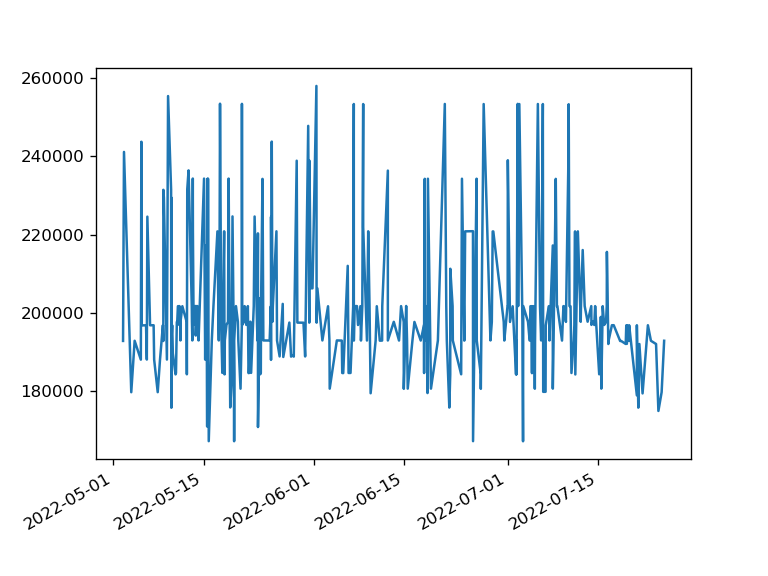

<AxesSubplot:>

In [6]:
%matplotlib notebook
cur_add['gasused'].apply(lambda x:float(x)).plot()

In [7]:
print(cur_ex[cur_ex['gasused']<np.inf]['gasused'].mean()) #, cur_ex['gasused'].mean()

145362.91372761803


In [8]:
print(cur_add[cur_add['gasused']<np.inf]['gasused'].mean())

200983.837535014


## use a wallet to estimate gas usage for transfer

In [9]:
contract1='0x83334ef0C6f6396413C508A7762741e9FD8B20E9' # a wallet
txs1 = eth.get_normal_transactions(address=contract1)

In [10]:
"""
tmp=pd.DataFrame()
for tx in txs1:
    #print(tx['functionName'])
    tmp.loc[tx['timeStamp'],'function']=tx['functionName']
"""

"\ntmp=pd.DataFrame()\nfor tx in txs1:\n    #print(tx['functionName'])\n    tmp.loc[tx['timeStamp'],'function']=tx['functionName']\n"

In [38]:
gas = pd.DataFrame() 
for tx in txs1:
    if tx['functionName'] == 'transfer(address _to, uint256 _value)':
        #print(tx['functionName'],tx['gasUsed'])
        gas.loc[tx['timeStamp'],'gasused'] = float(tx['gasUsed'])
        gas.loc[tx['timeStamp'],'gasprice'] = float(tx['gasPrice'])

In [39]:
gas.mean()

gasused     5.289333e+04
gasprice    6.788531e+10
dtype: float64

## sample calculation for batching based gas cost reduction

gas is computed in gas unit in this subsection 

In [13]:
add_liq_gas = cur_add[cur_add['gasused']<np.inf]['gasused'].mean()
ex_gas = cur_ex[cur_ex['gasused']<np.inf]['gasused'].mean()
transfer_gas = gas.mean()

In [14]:
print(add_liq_gas,ex_gas,transfer_gas)

200983.837535014 145362.91372761803 52893.333333333336


In [15]:
## assumption: batching requires transfer, smart contract execution, transfer

In [16]:
batch_user_number = 10

In [17]:
add_liq_costreduction = add_liq_gas - (add_liq_gas/batch_user_number + transfer_gas*2) 
add_liq_costreduction = add_liq_costreduction / add_liq_gas
print('add liquidity cost reduction',round(add_liq_costreduction*100,2) ,'%')

ex_costreduction = ex_gas - (ex_gas/batch_user_number + transfer_gas*2) 
ex_costreduction = ex_costreduction / add_liq_gas
print('swap cost reduction',round(ex_costreduction*100,2) ,'%')

add liquidity cost reduction 37.37 %
swap cost reduction 12.46 %


In [18]:
batch_user_number = 25

In [19]:
add_liq_costreduction = add_liq_gas - (add_liq_gas/batch_user_number + transfer_gas*2) 
add_liq_costreduction = add_liq_costreduction / add_liq_gas
print('add liquidity cost reduction',round(add_liq_costreduction*100,2) ,'%')

ex_costreduction = ex_gas - (ex_gas/batch_user_number + transfer_gas*2) 
ex_costreduction = ex_costreduction / add_liq_gas
print('swap cost reduction',round(ex_costreduction*100,2) ,'%')

add liquidity cost reduction 43.37 %
swap cost reduction 16.8 %


In [ ]:
#add_liq_gas = cur_add1['gasused'].mean()
#transfer_gas = gas[].mean()

## gas cost reduction with eth/usd price 

re-compute gas cost reduction denominated in usd 

In [21]:
base_url = 'https://ftx.com/api'

def get_price(token,start_time):
    """
    fetch historic p-i-t market price 
    """
    if token != 'WETH' and token != 'ETH':
        return 1
    else:
        
        market_name='ETH/USD'
        resolution = '60' 
        end_time = start_time + 60
        
        post_fix = '/markets/'+market_name+'/candles?resolution='+resolution+'&start_time='+str(start_time)+'&end_time='+str(end_time)
        a=requests.get(base_url + post_fix).json()
        return a['result'][0]['close']

In [47]:
#get_price('ETH',1658219190)
# 110066 * 9394611902 / 1e18 * get_price('ETH',1658219190)

In [32]:
def get_eth_price(df):
    for i in df.index:
        eth_ = get_price('ETH',int(df.loc[i,'timestamp']))
        df.loc[i,'eth_price'] = eth_
        time.sleep(0.1)
        print(i)
        
    return df

In [33]:
cur_add1 = cur_add[cur_add['gasused']<np.inf]
cur_add1 = get_eth_price(cur_add1)

2022-07-25 05:13:20
2022-07-24 19:53:14
2022-07-24 07:53:00
2022-07-23 23:12:25
2022-07-23 04:07:49
2022-07-22 16:53:39
2022-07-21 21:07:05
2022-07-21 09:17:57
2022-07-21 05:18:31
2022-07-20 23:56:53
2022-07-20 23:54:34
2022-07-19 19:22:30
2022-07-19 18:08:27
2022-07-19 15:49:46
2022-07-19 12:02:16
2022-07-19 10:39:08
2022-07-19 08:37:49
2022-07-19 06:35:38
2022-07-18 12:54:58
2022-07-18 09:55:58
2022-07-17 10:00:25
2022-07-17 03:17:59
2022-07-16 14:52:03
2022-07-16 14:02:09
2022-07-16 08:38:29
2022-07-16 08:12:27
2022-07-16 05:31:10
2022-07-15 22:33:06
2022-07-15 17:09:56
2022-07-15 11:56:40
2022-07-15 10:11:22
2022-07-15 08:54:50
2022-07-15 04:07:36
2022-07-14 13:05:17
2022-07-14 09:49:46
2022-07-14 08:25:36
2022-07-14 06:59:12
2022-07-14 02:26:34
2022-07-13 23:20:09
2022-07-13 22:41:21
2022-07-13 09:08:44
2022-07-12 22:13:27
2022-07-12 14:53:21
2022-07-12 08:28:34
2022-07-12 07:28:53
2022-07-11 20:54:52
2022-07-11 11:26:54
2022-07-11 10:29:58
2022-07-11 08:01:04
2022-07-11 05:34:03


In [45]:
#cur_ex1 = cur_ex[cur_ex['gasused']<np.inf]
#cur_ex1 = get_eth_price(cur_ex1)

In [43]:
gas['timestamp'] = gas.index
gas = get_eth_price(gas)

1658709803
1657566360
1655140126
1653428888
1652031691
1643876433
1643397959
1635737441
1633017345
1627104111
1614667280
1613982574


In [54]:
cur_add1['gascost']=cur_add1['gasused'].astype(float)*(cur_add1['gasprice'].astype(float))*cur_add1['eth_price']/1e18

In [55]:
gas['gascost']=gas['gasused'].astype(float)*(gas['gasprice'].astype(float))*gas['eth_price']/1e18

In [76]:
add_liq_gas = cur_add1['gascost'].mean()
transfer_gas = gas[:cur_add1['timestamp'].iloc[-1]]['gascost'].head(5).mean()

In [77]:
add_liq_gas,transfer_gas

(13.312496324036236, 2.593503118508136)

In [78]:
batch_user_number = 10

add_liq_costreduction = add_liq_gas - (add_liq_gas/batch_user_number + transfer_gas*2) 
add_liq_costreduction = add_liq_costreduction / add_liq_gas
print('add liquidity cost reduction',round(add_liq_costreduction*100,2) ,'%')

add liquidity cost reduction 51.04 %


In [79]:
batch_user_number = 25

add_liq_costreduction = add_liq_gas - (add_liq_gas/batch_user_number + transfer_gas*2) 
add_liq_costreduction = add_liq_costreduction / add_liq_gas
print('add liquidity cost reduction',round(add_liq_costreduction*100,2) ,'%')

add liquidity cost reduction 57.04 %
